In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
import matplotlib.pyplot as plt
import seaborn as sns
import umap

In [2]:
def read_annot_file(annot_path, vir_res, resolution):
    annot_df = pd.read_csv(annot_path, sep = "\t", header = None)
    annot_df = annot_df.iloc[:,0:4]
    if not vir_res:
        annot_df.iloc[:,1:3] = (annot_df.iloc[:,1:3]/resolution).astype(int)
    annot_df.columns = ['chr_name', 'start', 'end', 'label']
    return(annot_df)

def melt_annotation(annot_df):
    annot_df = annot_df.reset_index()
    melt = annot_df.melt(id_vars=['index', 'chr_name', 'label'], value_name = 'pos').drop('variable', axis=1)
    melt_annot_df = melt.groupby('index').apply(lambda x: x.set_index('pos', drop = False)\
                                    .reindex(range(x.loc[:,'pos'].values[0], x.loc[:,'pos'].values[1])))\
                                .ffill().drop(['pos','index'], axis = 1).reset_index(level = 'pos').reset_index(drop=True)
    return(melt_annot_df)
SC_annotation = read_annot_file("../../../data/annotations/Rao_SC.bed", 1, 100000)
SC_annotation = melt_annotation(SC_annotation)

In [24]:
def read_embedding_file(embedding_path, scaled):
    emb = pd.read_csv(embedding_path, sep = " ", header = None)
    emb.iloc[:,1] = (emb.iloc[:,1]/100000).astype(int)
    emb = emb.sort_values(by = [0,1])
    if scaled:
        emb.iloc[:,3:len(emb.columns)] = StandardScaler().fit_transform(emb.iloc[:,3:len(emb.columns)])
    for i in range(3,len(emb.columns)):
        emb = emb.rename(columns = {i: "emb" + str(i-2)})
    features = emb.iloc[:,3:len(emb.columns)]
    kmeans = KMeans(n_clusters=5)
    kmeans.fit(features)
    emb['kmeans_label'] = kmeans.predict(features)
    reducer = umap.UMAP()
    umaps = reducer.fit_transform(features)
    emb['umap1'] = umaps[:,0]
    emb['umap2'] = umaps[:,1]
    emb.drop(emb.columns[2], axis=1, inplace=True)
    emb = emb.rename(columns = {0:'chr_name', 1:'pos'})
    return(emb)
first_order = read_embedding_file("data/1st_order_embedding_d100.txt",0)
first_order = pd.merge(first_order, SC_annotation, how = 'inner', on = ['chr_name','pos'])
second_order = read_embedding_file("data/2nd_order_embedding_d100.txt",0)
second_order = pd.merge(second_order, SC_annotation, how = 'inner', on = ['chr_name','pos'])

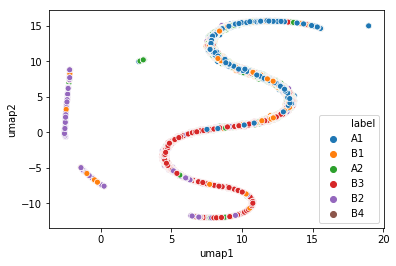

In [28]:
ax = sns.scatterplot(x="umap1", y="umap2", hue="label",
                     data=second_order)

In [49]:
def read_SNIPER_file(SNIPER_path, scaled):
    emb = pd.read_csv(SNIPER_path, sep = "\t", header = None)
    emb = emb.iloc[:,:len(emb.columns)-1]
    emb = emb.rename(columns = {0:'chr_name', 1:'pos'})
    for i in range(2,len(emb.columns)):
        emb = emb.rename(columns = {i: "emb" + str(i-1)})
    emb['chr_name'] = ["chr" + str(i) for i in emb['chr_name']]
    if scaled:
        emb.iloc[:,3:len(emb.columns)] = StandardScaler().fit_transform(emb.iloc[:,3:len(emb.columns)])
    features = emb.iloc[:,3:len(emb.columns)]
    kmeans = KMeans(n_clusters=5)
    kmeans.fit(features)
    emb['kmeans_label'] = kmeans.predict(features)
    reducer = umap.UMAP()
    umaps = reducer.fit_transform(features)
    emb['umap1'] = umaps[:,0]
    emb['umap2'] = umaps[:,1]
    return(emb)

In [50]:
SNIPER_emb = read_SNIPER_file("../../../data/embedding/SNIPER/SNIPER_embedding.txt", 0)
SNIPER_emb = pd.merge(SNIPER_emb, SC_annotation, how = 'inner', on = ['chr_name','pos'])
scaled_SNIPER_emb = read_SNIPER_file("../../../data/embedding/SNIPER/SNIPER_embedding.txt", 1)
scaled_SNIPER_emb = pd.merge(scaled_SNIPER_emb, SC_annotation, how = 'inner', on = ['chr_name','pos'])

In [67]:
odd_chromosomes = ["chr" + str(i) for i in range(1,23,2)]
even_chromosomes = ["chr" + str(i) for i in range(2,23,2)]

even_SNIPER_emb = SNIPER_emb[SNIPER_emb['chr_name'].isin(even_chromosomes)]
odd_SNIPER_emb = SNIPER_emb[SNIPER_emb['chr_name'].isin(odd_chromosomes)]
#SNIPER_emb

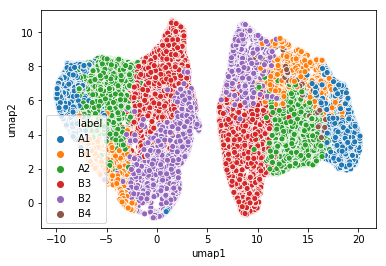

In [70]:

ax = sns.scatterplot(x="umap1", y="umap2", hue="label",
                     data=SNIPER_emb)

In [60]:
first_order.iloc[:,2:12].corr()

,emb1,emb2,emb3,emb4,emb5,emb6,emb7,emb8,emb9,emb10
emb1,1.000000,0.757992,0.843174,0.848621,-0.845035,0.836712,-0.837667,-0.847708,0.835090,-0.697202
emb2,0.757992,1.000000,0.886961,0.892327,-0.888222,0.879770,-0.880222,-0.891074,0.878133,-0.734326
emb3,0.843174,0.886961,1.000000,0.990987,-0.986930,0.977517,-0.977462,-0.989819,0.976436,-0.816669
emb4,0.848621,0.892327,0.990987,1.000000,-0.993072,0.983326,-0.983150,-0.995930,0.982170,-0.821699
emb5,-0.845035,-0.888222,-0.986930,-0.993072,1.000000,-0.979310,0.979309,0.991890,-0.978228,0.818579
emb6,0.836712,0.879770,0.977517,0.983326,-0.979310,1.000000,-0.969965,-0.982075,0.968721,-0.811652
emb7,-0.837667,-0.880222,-0.977462,-0.983150,0.979309,-0.969965,1.000000,0.982084,-0.968656,0.810934
emb8,-0.847708,-0.891074,-0.989819,-0.995930,0.991890,-0.982075,0.982084,1.000000,-0.980954,0.821109
emb9,0.835090,0.878133,0.976436,0.982170,-0.978228,0.968721,-0.968656,-0.980954,1.000000,-0.808964
emb10,-0.697202,-0.734326,-0.816669,-0.821699,0.818579,-0.811652,0.810934,0.821109,-0.808964,1.000000


In [22]:
np.unique(GW_compartments, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int32),
 array([17008,   169,  9297,   179,   323]))

In [10]:
p = pd.DataFrame({"first_order_labels" : GW_compartments, "second_order_labels": GW_compartments2})

In [14]:
p.groupby(["first_order_labels", "second_order_labels"]).size()

first_order_labels  second_order_labels
0                   0                        221
                    1                        488
                    4                       8334
1                   0                          1
                    2                         50
                    3                        191
2                   0                      10192
                    4                       1653
3                   1                       5209
                    2                         44
                    4                        236
4                   1                         24
                    2                        313
                    3                         20
dtype: int64

In [20]:
np.unique(GW_compartments2, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int32),
 array([ 9912,   426, 10846,  5572,   220]))

In [8]:
scaled_first_order_features = StandardScaler().fit_transform(first_order_features)

In [12]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(scaled_first_order_features)
GW_compartments = kmeans.predict(scaled_first_order_features)

In [34]:
np.unique(GW_compartments, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6], dtype=int32),
 array([8358,  168, 4306,  179,  298, 5452, 8215]))

In [10]:
import umap

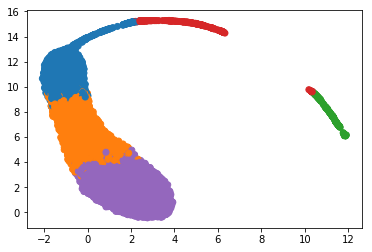

In [13]:
#reducer = umap.UMAP()
#embedding = reducer.fit_transform(scaled_first_order_features)
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in GW_compartments])
#plt.gca().set_aspect('equal', 'datalim')
#plt.title('UMAP projection of the Penguin dataset', fontsize=24)

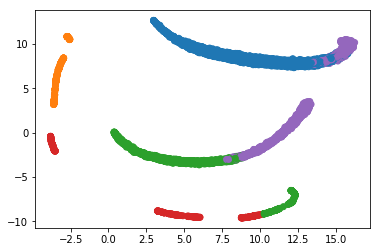

In [30]:
#reducer2 = umap.UMAP()
#embedding2 = reducer2.fit_transform(first_order_features)
plt.scatter(
    embedding2[:, 0],
    embedding2[:, 1],c=[sns.color_palette()[x] for x in GW_compartments])
#plt.gca().set_aspect('equal', 'datalim')
#plt.title('UMAP projection of the Penguin dataset', fontsize=24)

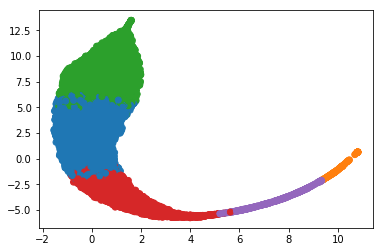

In [23]:
#reducer3 = umap.UMAP()
#embedding3 = reducer3.fit_transform(second_order_features)
plt.scatter(
    embedding3[:, 0],
    embedding3[:, 1],c=[sns.color_palette()[x] for x in GW_compartments2])
#plt.gca().set_aspect('equal', 'datalim')
#plt.title('UMAP projection of the Penguin dataset', fontsize=24)

In [27]:
def elbow(df, n):
    kMeansVar = [KMeans(n_clusters=k).fit(df.values) for k in range(1, n)]
    centroids = [X.cluster_centers_ for X in kMeansVar]
    k_euclid = [cdist(df.values, cent) for cent in centroids]
    dist = [np.min(ke, axis=1) for ke in k_euclid]
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(df.values)**2)/df.values.shape[0]
    bss = tss - wcss
    plt.plot(bss/tss)
    plt.show()

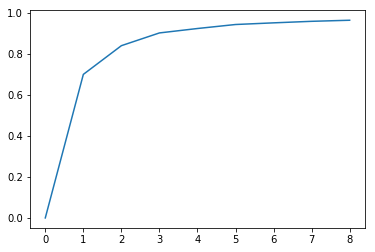

In [28]:
elbow(first_order_features,10)

In [60]:
def LINE_output_to_wigfix(input_df, output_dir_path, num_embed):
    if not os.path.exists(output_dir_path):
        os.makedirs(output_dir_path)
    embed = []
    for e in range(num_embed):
        embed.append(
            open(os.path.join(output_dir_path, "embedding" + str(e+1) + ".wigfix"), "w"))
    i = 0
    while i < input_df.shape[0]:
        header = ("fixedStep chrom=" + input_df.iloc[i,0] + " start=" +
                  str(input_df.iloc[i,1]+1) + " step=1 span=1")
        for e in range(num_embed):
            embed[e].write(header)
            embed[e].write("\n")
            embed[e].write(str(input_df.iloc[i,e+3]))
            embed[e].write("\n")
        i = i + 1
        while input_df.iloc[i,1] == input_df.iloc[i-1,1]+1:
            for e in range(num_embed):
                embed[e].write(str(input_df.iloc[i,e+3]))
                embed[e].write("\n")
            i = i + 1
            if i == input_df.shape[0]:
                break

In [56]:
#first_order.iloc[:,1] = [int(f/100000) for f in first_order.iloc[:,1]]
#first_order.iloc[:,2] = [int(f/100000) for f in first_order.iloc[:,2]]
#second_order.iloc[:,1] = [int(f/100000) for f in second_order.iloc[:,1]]
#second_order.iloc[:,2] = [int(f/100000) for f in second_order.iloc[:,2]]

In [62]:
import os
LINE_output_to_wigfix(first_order,"LINE_1st_d10",10)
#LINE_output_to_wigfix(second_order,"LINE_2nd_d10",10)

In [58]:
with open("LINE_2nd_d10/embedding10.wigfix") as f:
    for line in f:
        l = line.split()
        if l[0] == "fixedStep":
            print(l)

['fixedStep', 'chrom=chr1', 'start=0', 'step=1', 'span=1']
['fixedStep', 'chrom=chr1', 'start=300', 'step=1', 'span=1']
['fixedStep', 'chrom=chr1', 'start=1039', 'step=1', 'span=1']
['fixedStep', 'chrom=chr1', 'start=1425', 'step=1', 'span=1']
['fixedStep', 'chrom=chr1', 'start=1431', 'step=1', 'span=1']
['fixedStep', 'chrom=chr1', 'start=1485', 'step=1', 'span=1']
['fixedStep', 'chrom=chr10', 'start=0', 'step=1', 'span=1']
['fixedStep', 'chrom=chr10', 'start=423', 'step=1', 'span=1']
['fixedStep', 'chrom=chr10', 'start=465', 'step=1', 'span=1']
['fixedStep', 'chrom=chr10', 'start=469', 'step=1', 'span=1']
['fixedStep', 'chrom=chr10', 'start=483', 'step=1', 'span=1']
['fixedStep', 'chrom=chr11', 'start=1', 'step=1', 'span=1']
['fixedStep', 'chrom=chr11', 'start=511', 'step=1', 'span=1']
['fixedStep', 'chrom=chr11', 'start=547', 'step=1', 'span=1']
['fixedStep', 'chrom=chr11', 'start=964', 'step=1', 'span=1']
['fixedStep', 'chrom=chr12', 'start=0', 'step=1', 'span=1']
['fixedStep', 'chr

In [59]:
with open("../../../Hi-C+ChIP-seq-Chromatin-State-Annotation/data/embedding/LINE_whole_100k/emb1.wigfix") as f:
    for line in f:
        l = line.split()
        if l[0] == "fixedStep":
            print(l)

['fixedStep', 'chrom=chr1', 'start=1', 'step=1']
['fixedStep', 'chrom=chr1', 'start=301', 'step=1']
['fixedStep', 'chrom=chr1', 'start=1040', 'step=1']
['fixedStep', 'chrom=chr1', 'start=1426', 'step=1']
['fixedStep', 'chrom=chr1', 'start=1432', 'step=1']
['fixedStep', 'chrom=chr1', 'start=1486', 'step=1']
['fixedStep', 'chrom=chr2', 'start=1', 'step=1']
['fixedStep', 'chrom=chr2', 'start=899', 'step=1']
['fixedStep', 'chrom=chr2', 'start=905', 'step=1']
['fixedStep', 'chrom=chr2', 'start=916', 'step=1']
['fixedStep', 'chrom=chr2', 'start=954', 'step=1']
['fixedStep', 'chrom=chr2', 'start=1108', 'step=1']
['fixedStep', 'chrom=chr2', 'start=1114', 'step=1']
['fixedStep', 'chrom=chr3', 'start=1', 'step=1']
['fixedStep', 'chrom=chr3', 'start=936', 'step=1']
['fixedStep', 'chrom=chr4', 'start=1', 'step=1']
['fixedStep', 'chrom=chr4', 'start=527', 'step=1']
['fixedStep', 'chrom=chr5', 'start=1', 'step=1']
['fixedStep', 'chrom=chr5', 'start=495', 'step=1']
['fixedStep', 'chrom=chr5', 'start=